# Create VAE, Sequential model instances

In [21]:
from keras.models import Model
from keras.layers import Dense, Flatten, Input, Lambda, Dropout
from keras.layers.merge import concatenate
from keras import backend as K
import molecule_vae
from molecule_vae import get_zinc_tokenizer
import zinc_grammar
from vectorized_cmap import computecs
import h5py

In [22]:
visible_1 = Input(shape=(978, 2))
flaten_1_sq = Flatten()(visible_1)
dense_11 = Dense(1024, activation='relu')(flaten_1_sq)
drop_1 = Dropout(0.2)(dense_11)
dense_12 = Dense(512, activation='relu')(drop_1)
drop_2 = Dropout(0.2)(dense_12)
dense_13 = Dense(256, activation='relu')(drop_2)
drop_3 = Dropout(0.2)(dense_13)
dense_14 = Dense(128, activation='relu')(drop_3)
drop_4 = Dropout(0.2)(dense_14)
dense_15 = Dense(56, activation='relu')(drop_4)
output_1 = Dense(1, activation='linear')(dense_15)
sequential = Model(inputs=visible_1, outputs=output_1)

In [3]:
# # sequential model 2
# visible_2 = Input(shape=(978, 10))
# flatten_2 = Flatten()(visible_2)
# dense_21 = Dense(1024, activation='relu')(flatten_2)
# dense_22 = Dense(512, activation='relu')(dense_21)
# output_2 = Dense(1, activation='linear')(dense_22)
# model_2 = Model(inputs=visible_2, outputs=output_2)
# model_2.summary()

# Load the weights for VAE, Sequential model

In [4]:
# Load the saved weights into the first and second models

# path = "../code/DLEPS/sequential.h5"
# model_1.load_weights(path)
# model_2.load_weights(path)

In [4]:
# Load the saved weights for the vae and sequential models

vae_weights_path = '../../data/vae.hdf5'
sequential_weights_path = '../../data/sequential.h5'

In [23]:
# Load weights to vae and sequential models

grammar_model = molecule_vae.ZincGrammarModel(vae_weights_path)
sequential.load_weights(sequential_weights_path)

# Concatenate outputs of the models

In [24]:
def sampling(args):
    z_mean_, z_log_var_ = args
    batch_size = K.shape(z_mean_)[0]
    epsilon = K.random_normal(shape=(batch_size, 56), mean=0., stddev = 0.01)
    return z_mean_ + K.exp(z_log_var_ / 2) * epsilon

In [25]:
z_mn, z_var = grammar_model.vae.encoderMV.output
visible_vae = grammar_model.vae.encoderMV.input
output_vae = Lambda(sampling, output_shape=(56,), name='lambda')([z_mn, z_var])

In [26]:
grammar_model = Model(inputs=visible_vae, outputs=output_vae)
grammar_model.summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 277, 76)      0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 269, 9)       6165        input_11[0][0]                   
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, 261, 9)       738         conv_1[0][0]                     
__________________________________________________________________________________________________
conv_3 (Conv1D)                 (None, 251, 10)      1000        conv_2[0][0]                     
___________________________________________________________________________________________

In [27]:
# merge input models
merge = concatenate([dense_15, output_vae])

# interpretation model
x = Dense(512,activation='relu')(merge)
x = Dropout(0.4)(x)
x = Dense(512,activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(512,activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(512,activation='tanh')(x)
x = Dropout(0.4)(x)
outputs = Dense(1, activation='linear')(x)
model = Model(inputs=[visible_1, visible_vae], outputs=outputs)

# summarize layers
print(model.summary())

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 978, 2)       0                                            
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 1956)         0           input_7[0][0]                    
__________________________________________________________________________________________________
dense_35 (Dense)                (None, 1024)         2003968     flatten_3[0][0]                  
__________________________________________________________________________________________________
dropout_25 (Dropout)            (None, 1024)         0           dense_35[0][0]                   
___________________________________________________________________________________________

# Compile merged model

In [28]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])  # Adjust optimizer and loss as needed

# Load datasets

In [29]:
import h5py

h5f = h5py.File('../../data/vae_train.h5', 'r')
vae_train = h5f['data'][:]
h5f = h5py.File('../../data/vae_test.h5', 'r')
vae_test = h5f['data'][:]
h5f = h5py.File('../../data/gene_exp_data_train.h5', 'r')
seq_train = h5f['data'][:]
h5f = h5py.File('../../data/gene_exp_data_test.h5', 'r')
seq_test = h5f['data'][:]
h5f2 = h5py.File('../../data/y_train.h5', 'r')
y_train = h5f2['data'][:]
h5f2 = h5py.File('../../data/y_test.h5', 'r')
y_test = h5f2['data'][:]
# h5f3 = h5py.File('../../data/gene_exp_data_test.h5', 'r')
# seq_test = h5f3['data'][:]
# h5f4 = h5py.File('../../data/gene_exp_labels_test.h5', 'r')
# seq_labels = h5f4['data'][:]

print(vae_train.shape)
print(vae_test.shape)
print(seq_train.shape)
print(seq_test.shape)
print(y_train.shape)
print(y_test.shape)

(350, 277, 76)
(75, 277, 76)
(350, 978, 2)
(75, 978, 2)
(350,)
(75,)


# Train the combined model

In [30]:
# Use the final model to get a single output
epochs = 100
batch_size = 50
lr = 0.01
model.fit([seq_train, vae_train], y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/100
350/350 [==============================] - 2s 5ms/step - loss: 0.1410 - mae: 0.2918
Epoch 2/100
350/350 [==============================] - 1s 3ms/step - loss: 0.0451 - mae: 0.1650
Epoch 3/100
350/350 [==============================] - 1s 3ms/step - loss: 0.0327 - mae: 0.1380
Epoch 4/100
350/350 [==============================] - 1s 3ms/step - loss: 0.0337 - mae: 0.1328
Epoch 5/100
350/350 [==============================] - 1s 3ms/step - loss: 0.0245 - mae: 0.1222
Epoch 6/100
350/350 [==============================] - 1s 3ms/step - loss: 0.0300 - mae: 0.1270
Epoch 7/100
350/350 [==============================] - 1s 3ms/step - loss: 0.0292 - mae: 0.1243
Epoch 8/100
350/350 [==============================] - 1s 3ms/step - loss: 0.0241 - mae: 0.1109
Epoch 9/100
350/350 [==============================] - 1s 3ms/step - loss: 0.0279 - mae: 0.1255
Epoch 10/100
350/350 [==============================] - 1s 3ms/step - loss: 0.0210 - mae: 0.1106
Epoch 11/100
350/350 [=================

# Evalaute the model

In [31]:
# Evaluate the model on the test set
results = model.evaluate([seq_test, vae_test], y_test, batch_size=batch_size)

75/75 [==============================] - 0s 5ms/step


In [32]:
# Print the evaluation results
print("Validation Loss:", results[0])
print("Validation MAE:", results[1])

Validation Loss: 0.15102478861808777
Validation MAE: 0.3135371208190918


# Save model weights

In [25]:
model.save_weights('../../data/vae_sequential.h5')
print("Model weights saved to 'vae_sequential.h5'")

# model.load_weights('../../data/vae_sequential.h5')

Model weights saved to 'vae_sequential.h5'


In [34]:
y_pred = model.predict([seq_test, vae_test])

[[1.        0.3632266]
 [0.3632266 1.       ]]
0.12088778746304618


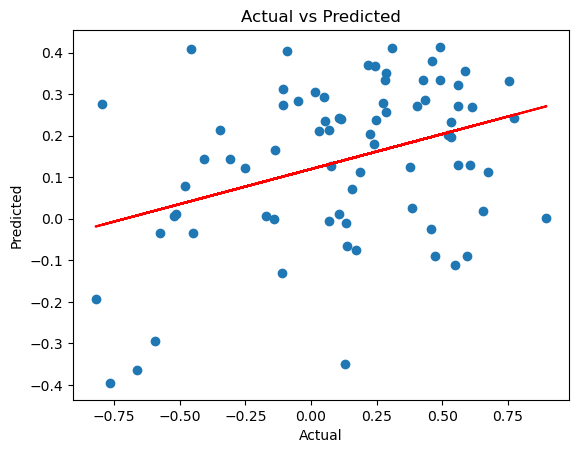

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import numpy as np
print(np.corrcoef(y_test, y_pred.ravel()))
print(r2_score(y_test, y_pred))
plt.scatter(y_test, y_pred)
m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m * y_test + b, 'r')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

# Finish!

# Test the model

In [26]:
# Load test set for gene expression data
h5f = h5py.File('../../data/gene_exp_test_data.h5', 'r')
seq_test_data = h5f['data'][:]
h5f = h5py.File('../../data/vae_test_data.h5', 'r')
vae_test_data = h5f['data'][:]

print(seq_test_data.shape)
print(vae_test_data.shape)

(910, 978, 2)
(910, 277, 76)


In [27]:
vae_input = vae_test_data
sequential_input = seq_test_data
ytest = model.predict([sequential_input, vae_input])

In [28]:
len(ytest)

910

# Add drugs column, sort the dataframe according to best score in descending order, select top 100

In [29]:
import pandas as pd
df_drugs = pd.read_csv('../../data/vae_drugs.csv')
df_drugs

,drug_name,SMILES,standardized_SMILES
0,acadesine,C1=NC(=C(N1C2C(C(C(O2)CO)O)O)N)C(=O)N,NC(=O)c1ncn(C2OC(CO)C(O)C2O)c1N
1,acamprosate,CC(=O)NCCCS(=O)(=O)O,CC(=O)NCCCS(=O)(=O)O
2,acarbose,CC1C(C(C(C(O1)OC2C(OC(C(C2O)O)OC3C(OC(C(C3O)O)...,CC1OC(OC2C(CO)OC(OC3C(CO)OC(O)C(O)C3O)C(O)C2O)...
3,acea,CCCCCC=CCC=CCC=CCC=CCCCC(=O)NCCCl,CCCCCC=CCC=CCC=CCC=CCCCC(=O)NCCCl
4,acebutolol,CCCC(=O)NC1=CC(=C(C=C1)OCC(CNC(C)C)O)C(=O)C,CCCC(=O)Nc1ccc(OCC(O)CNC(C)C)c(C(C)=O)c1
...,...,...,...
905,fluvastatin,CC(C)N1C2=CC=CC=C2C(=C1C=CC(CC(CC(=O)O)O)O)C3=...,CC(C)n1c(C=CC(O)CC(O)CC(=O)O)c(-c2ccc(F)cc2)c2...
906,fluvoxamine,COCCCCC(=NOCCN)C1=CC=C(C=C1)C(F)(F)F,COCCCCC(=NOCCN)c1ccc(C(F)(F)F)cc1
907,fmk,CC1=CC=C(C=C1)C2=C(N(C3=NC=NC(=C23)N)CCCO)C(=O)CF,Cc1ccc(-c2c(C(=O)CF)n(CCCO)c3ncnc(N)c23)cc1
908,folic-acid,C1=CC(=CC=C1C(=O)NC(CCC(=O)O)C(=O)O)NCC2=CN=C3...,Nc1nc2ncc(CNc3ccc(C(=O)NC(CCC(=O)O)C(=O)O)cc3)...


In [30]:
result_df = pd.DataFrame(columns=['drug_name', 'SMILES', 'score'])
result_df['drug_name'] = list(df_drugs['drug_name'])
result_df['SMILES'] = list(df_drugs['standardized_SMILES'])
result_df['score'] = ytest
result_df = result_df.sort_values('score', ascending=False)
result_df

,drug_name,SMILES,score
536,cyclothiazide,NS(=O)(=O)c1cc2c(cc1Cl)NC(C1CC3C=CC1C3)NS2(=O)=O,0.872713
719,efaroxan,CCC1(C2=NCCN2)Cc2ccccc2O1,0.764166
175,astemizole,COc1ccc(CCN2CCC(Nc3nc4ccccc4n3Cc3ccc(F)cc3)CC2...,0.655603
433,chrysophanic-acid,Cc1cc(O)c2c(c1)C(=O)c1cccc(O)c1C2=O,0.623146
641,diisononyl-phthalate,CC(C)CCCCCCOC(=O)c1ccccc1C(=O)OCCCCCCC(C)C,0.608616
...,...,...,...
119,amprenavir,CC(C)CN(CC(O)C(Cc1ccccc1)NC(=O)OC1CCOC1)S(=O)(...,-0.516846
24,actinomycin-d,Cc1c2oc3c(C)ccc(C(=O)NC4C(=O)NC(C(C)C)C(=O)N5C...,-0.523516
31,adipamide,NC(=O)CCCCC(N)=O,-0.532908
84,amanitin,CCC(C)C1NC(=O)CNC(=O)C2Cc3c([nH]c4cc(O)ccc34)S...,-0.540386


In [ ]:
result_df.to_csv('../../data/combined_model_results_910.csv', index=False)
result_df[:100].to_csv('../../data/combined_model_results_top_100.csv', index=False)

# Finish!